In [1]:
import getpass
import sys
import pandas as pd
import string
import numpy as np

from src.common.authentication import Authentication
from src.common.perspective_api_request import PerspectiveAPIRequest, PerspectiveAPIRequestResult
from src.common.request import Request, RequestResult
from src.proxy.accounts import Account
from proxy.remote_service import RemoteService

from os.path import exists

In [2]:
import json

with open("boolQA/data/train.jsonl") as f:
    df = pd.DataFrame(json.loads(line) for line in f)

In [3]:
# An example of how to use the request API.
#api_key = getpass.getpass(prompt="Enter a valid API key: ")
api_key = pd.read_csv("prod_env/api_key.csv", header=None)[0].values[0]
auth = Authentication(api_key=api_key)
service = RemoteService("https://crfm-models.stanford.edu")

# Access account and show my current quotas and usages
account: Account = service.get_account(auth)
print(account.usages)

{'gpt3': {'daily': Usage(period='2022-8-15', used=109497, quota=None), 'total': Usage(period='all', used=196805, quota=400000), 'monthly': Usage(period='2022-8', used=159608, quota=None)}, 'codex': {'daily': Usage(period=None, used=0, quota=0)}, 'jurassic': {'daily': Usage(period=None, used=0, quota=None), 'total': Usage(period=None, used=0, quota=0)}, 'gooseai': {'daily': Usage(period=None, used=0, quota=0)}}


In [4]:
sample_questions = df.sample(n=100).reset_index()
sample_questions.to_csv("boolQA/data/sample_questions.csv", index=False)

sample_examples = df.sample(n=100).reset_index()
sample_examples.to_csv("boolQA/data/sample_examples.csv", index=False)
sample_examples.columns = [x + "_example" for x in sample_examples.columns]

In [5]:
#create a paired dataset
sample_questions = pd.concat([sample_questions, sample_examples], axis=1)
sample_questions.to_csv("boolQA/data/sample_questions1.csv")

In [6]:
NUM_COMPLETIONS = 1
MAX_TOKENS = 50
TEMPERATURE = 0.7
MODEL_NAME = "openai/davinci"
ECHO_PROMPT = False

prompt_responses = pd.DataFrame()

sample_questions = pd.read_csv("boolQA/data/sample_questions1.csv")

PATH = 'boolQA/results/'
OUTPUT_FILE = PATH + str(MAX_TOKENS) + "_" + str(TEMPERATURE)[-1:] + "_" + MODEL_NAME[7:] + '.csv'
STOP_SEQUENCES = ["?", ".", "!", "\n"]

prefixes = ["Maybe it's",
    "I don't know, maybe it's",
    "I'm pretty sure it's",
    "I believe it's",
     "I'm guessing it's", 
    "I think it's"]

# prefixes = [""]

# for n, row in sample_questions[50:].iterrows():
#     print(n)

#     example_question = row['question_example']
#     example_answer = row['answer_example']

#     question = row['question']
#     answer = row['answer']
    
#     title = row['title']

#     for prefix in prefixes:
#         example = "Q: " + example_question + "\nA: " + prefix + " " + str(example_answer) + "."
#         prompt  = example + "\nQ: " + question + "\nA: " + prefix
#         print(prompt)
#         print("-----")
#         print("answer: ", answer)
#         print("-----")
#         request = Request(prompt=prompt, temperature=TEMPERATURE, model=MODEL_NAME, num_completions=NUM_COMPLETIONS, max_tokens=MAX_TOKENS, stop_sequences=STOP_SEQUENCES, echo_prompt=ECHO_PROMPT)
#         request_result: RequestResult = service.make_request(auth, request)

#         for response in request_result.completions:
#             print("prediction: ", response.text, "\t",  response.logprob)
#             print("-----")
#             prompt_responses = pd.concat([prompt_responses, pd.DataFrame([[prompt, example_question, example_answer, question, answer, title, prefix, response.text, response.logprob]])])
#         print("title: ", title)
#         print("-----")

# prompt_responses.to_csv(OUTPUT_FILE, mode='a', header=False, index=False)


In [7]:
# prompt_responses.to_csv(OUTPUT_FILE, mode='a', header=False, index=False)


In [25]:
#lowercase, remove punctuation
def remove_punctuation(str_input):
    return str_input.translate(str.maketrans('', '', string.punctuation))

def check_answer_aliases(answer, prediction):

    answer = remove_punctuation(answer.lower())
    prediction = remove_punctuation(prediction.lower().strip(" "))

    if answer == "true":
        if prediction == 'yes' or prediction == 'true' or 'yes' in prediction:
            return 1
    if answer == "false":
        if prediction == 'no' or prediction == 'false' or 'no' in prediction:
            return 1
    return 0

    
def answer_converter(prediction, answer):
    original_prediction = prediction
    
    answer = remove_punctuation(answer.lower())
    prediction = remove_punctuation(prediction.lower().strip(" "))

    if answer == "true":
        if prediction == 'yes' or prediction == 'true' or 'yes' in prediction:
            return "True"
    if answer == "false":
        if prediction == 'no' or prediction == 'false' or 'no' in prediction:
            return "False"
    return original_prediction.strip(" ")
    
    

In [26]:
result = pd.read_csv(OUTPUT_FILE, header=None).drop_duplicates()
result.columns=['prompt', 'example_question', 'example_answer', 'question', 'answer', 'title', 'prefix', 'prediction', 'logprob']
result['prefix'] = result['prefix'].fillna("unprompted")
result = result.dropna()
#check if the prediction is in the answer
# result['correct'] = result.apply(lambda x: check_answer_aliases(str(x['answer']), str(x['prediction'])), axis=1)

result['answer'] = result['answer'].astype(str)
result['prediction_normalized'] = result.apply(lambda x: answer_converter(str(x['prediction']), str(x['answer'])), axis=1)
result['correct'] = result.apply(lambda x: 1 if (str(x['answer']) == str(x['prediction_normalized'])) else 0, axis=1)



In [27]:
result.groupby('prefix').mean().sort_values(by='correct')


,example_answer,logprob,correct
prefix,,,
I'm pretty sure it's,0.6,-1.122329,0.47
I believe it's,0.6,-1.120946,0.48
unprompted,0.6,-6.571368,0.48
"I don't know, maybe it's",0.6,-0.574365,0.49
I think it's,0.6,-1.223091,0.51
I'm guessing it's,0.6,-1.341794,0.56
Maybe it's,0.6,-0.416070,0.57


In [28]:
result.loc[result.groupby('example_question').logprob.idxmax()].sum()



prompt                   Q: a standard voltage for homes in the united ...
example_question         a standard voltage for homes in the united sta...
example_answer                                                          60
question                 was wizard of oz in color in 1939was fox news ...
answer                   TrueTrueTrueFalseFalseTrueFalseFalseTrueFalseT...
title                    The Wizard of Oz (1939 film)History of Fox New...
prefix                   I think it'sMaybe it'sI don't know, maybe it's...
prediction                False True True True True True False False Tr...
logprob                                                         -23.782305
prediction_normalized    FalseTrueTrueTrueTrueTrueFalseFalseTrueTrueTru...
correct                                                                 49
dtype: object

In [37]:
#converting to probabilities
result['prob'] = result['logprob'].apply(lambda x: np.e**x)
#probability of True
result['positive_prob'] = result.apply(lambda x: ((1 - x['prob']) if (x['prediction_normalized'] == "False") else x['prob']), axis=1)
filtered_result = result[result['prediction_normalized'].isin(set(['False', 'True']))]
filtered_result

,prompt,example_question,example_answer,question,answer,title,prefix,prediction,logprob,prediction_normalized,correct,prob,positive_prob
0,Q: is the movie talk to me based on a true sto...,is the movie talk to me based on a true story,True,can the president of the philippines be re ele...,False,President of the Philippines,unprompted,"No, the president can only be elected once",-8.974628,False,1,1.265810e-04,9.998734e-01
3,Q: did remains of the day win any oscars\nA: F...,did remains of the day win any oscars,False,can u marry a dead person in france,True,Posthumous marriage,unprompted,False,-1.154615,False,0,3.151790e-01,6.848210e-01
4,Q: is the book of james in the new testament\n...,is the book of james in the new testament,True,can a state supreme court decision be appealed,True,State supreme court,unprompted,"Yes, but not to the US Supreme Court",-8.736688,True,1,1.605849e-04,1.605849e-04
5,Q: is the show patrick melrose based on a true...,is the show patrick melrose based on a true story,True,can professional athletes play in the winter o...,True,Amateur sports,unprompted,"yes, they ca",-14.527637,True,1,4.906000e-07,4.906000e-07
6,Q: is there a such thing as teacup pigs\nA: Fa...,is there a such thing as teacup pigs,False,does the cat die in hide and seek,True,Hide and Seek (2005 film),unprompted,yes,-2.455438,True,1,8.582562e-02,8.582562e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,Q: does mike come out of a coma in desperate h...,does mike come out of a coma in desperate hous...,True,is there a children's day in america,True,Children's Day,"I don't know, maybe it's",True,-0.355421,True,1,7.008785e-01,7.008785e-01
696,Q: does mike come out of a coma in desperate h...,does mike come out of a coma in desperate hous...,True,is there a children's day in america,True,Children's Day,I'm pretty sure it's,True,-1.087074,True,1,3.372016e-01,3.372016e-01
697,Q: does mike come out of a coma in desperate h...,does mike come out of a coma in desperate hous...,True,is there a children's day in america,True,Children's Day,I believe it's,True,-0.872574,True,1,4.178744e-01,4.178744e-01
698,Q: does mike come out of a coma in desperate h...,does mike come out of a coma in desperate hous...,True,is there a children's day in america,True,Children's Day,I'm guessing it's,False,-0.521827,False,0,5.934351e-01,4.065649e-01


In [38]:
def prediction_converter(x):
    x = x.strip(" ").lower()
    if x == 'true' or x == 'yes':
        return 1
    elif x == "false" or x == 'no':
        return 0
    else:
        return -1
result['answer_binary'] = result['answer'].apply(lambda x: prediction_converter(str(x)))


In [40]:
import sklearn
from sklearn.metrics import brier_score_loss

for n, group in result.groupby('prefix'):
    print(n, brier_score_loss(group['answer_binary'].values, group['positive_prob'].values))
    

I believe it's 0.28774527052113064
I don't know, maybe it's 0.3161870139006063
I think it's 0.2915608453299902
I'm guessing it's 0.3010912129187558
I'm pretty sure it's 0.31486741510669375
Maybe it's 0.31238526070748523
unprompted 0.5313962839864171


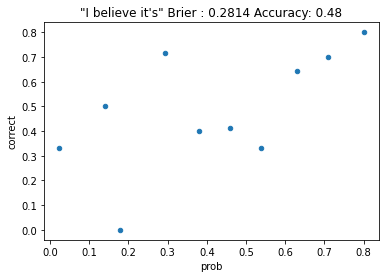

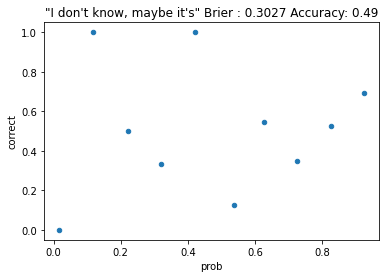

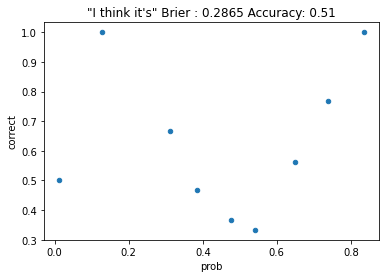

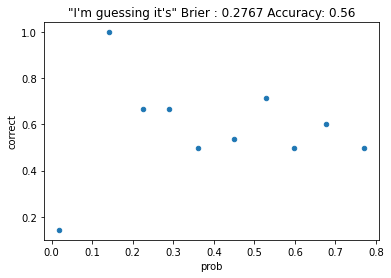

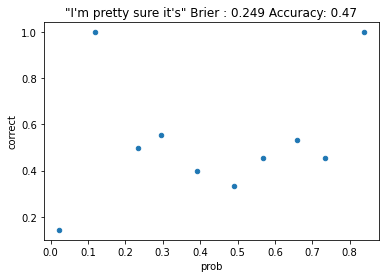

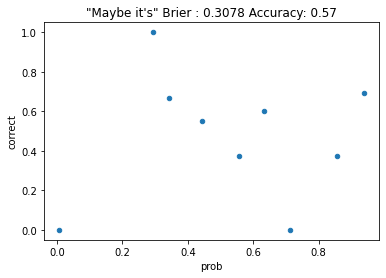

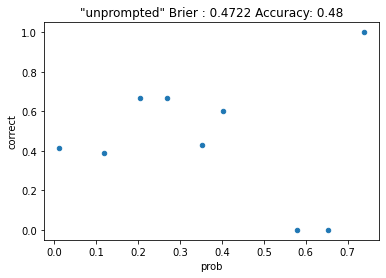

In [41]:
import numpy as np
import sklearn
from sklearn.metrics import brier_score_loss

grouped = result.groupby("prefix")
    
for prefix, group in grouped:
    accuracy = group['correct'].mean()
    group['prob_bins'] = pd.cut(np.array(group['positive_prob'].values), 10)
#     group = group.groupby('prob').mean()
    brier_score = brier_score_loss(group['answer_binary'].values, group['positive_prob'].values)
    group = group.groupby('prob_bins').mean().reset_index().sort_values(by='prob_bins').reset_index()
    group.plot.scatter(x='positive_prob', y='correct', title= "\"" + prefix + "\"" + " Brier : " + str(round(brier_score, 4)) + " Accuracy: " + str(round(accuracy, 4)))

